In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import PchipInterpolator, CubicSpline, UnivariateSpline
from scipy.optimize import minimize_scalar, differential_evolution

import math

from easygsvd import gsvd as gsvd_func
from easygsvd import random_rank_matrix

import jlinops

import os
import sys
sys.path.append("../..")


from scipy.sparse.linalg import aslinearoperator

from pytikhonov import lcorner, TikhonovFamily, discrepancy_principle, lcorner, find_lcurve_corner, plot_rdata, picard_plot, gcvmin, all_regparam_methods
from pytikhonov import rand_discrepancy_principle, rand_lcurve, rand_lcorner, rand_gcvmin
from pytikhonov import plot_gcv, plot_dp, plot_lcorner, plot_all_methods, picard_plot
from pytikhonov import golub_kahan
from pytikhonov import estimate_noise_variance, plot_monitoring_function

from pytikhonov import ProjectedTikhonovFamily

Forward interpolation check:
  max abs error  = 1.839e-03
  relative L2 err= 1.323e-03

LSQR fit to noisy data:
  ||A y_new_fit - y_noisy||_2 = 3.025e-01
  iters = 52, flag = 2



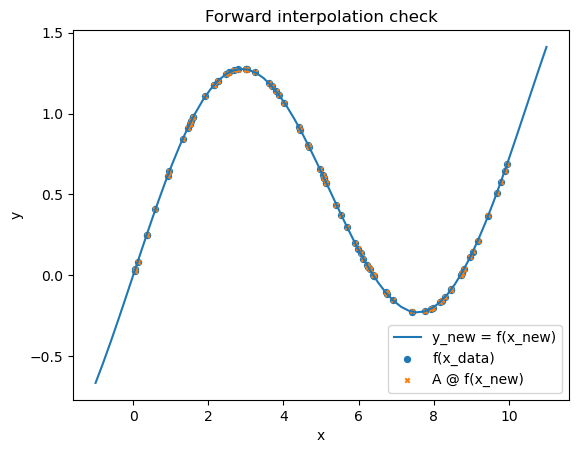

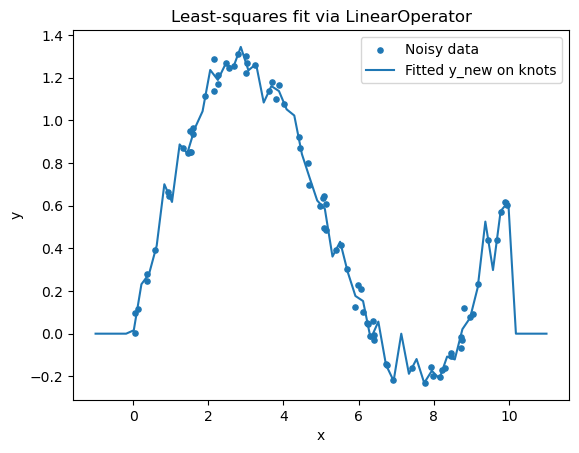

In [ ]:
# Simplified implementation: just the operator and a numerical test (no file saving).
import numpy as np
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

def linear_interpolation_operator(x_data, x_new, *, extrapolate=True, dtype=None):
    """
    Build a LinearOperator A such that (A @ y_new) yields values at x_data
    from simple linear interpolation of y_new defined on knots x_new.
    
    x_data : (m,) array_like   (may be unsorted and contain duplicates)
    x_new  : (n,) array_like   (must be strictly increasing; no duplicates)
    extrapolate : bool
        If True, allow linear extrapolation outside [x_new[0], x_new[-1]].
        If False, clamp to endpoints (constant extension).
    """
    x_data = np.asarray(x_data, dtype=float).ravel()
    x_new = np.asarray(x_new, dtype=float).ravel()
    if x_new.ndim != 1 or x_data.ndim != 1:
        raise ValueError("x_data and x_new must be 1D arrays")
    if x_new.size < 2:
        raise ValueError("x_new must have at least two points")
    if np.any(np.diff(x_new) <= 0):
        raise ValueError("x_new must be strictly increasing (no duplicates)")
    if not np.all(np.isfinite(x_data)) or not np.all(np.isfinite(x_new)):
        raise ValueError("x_data and x_new must be finite")
    
    m = x_data.size
    n = x_new.size
    
    # For each x_data[i], pick interval [x_new[j], x_new[j+1]]
    j_left = np.searchsorted(x_new, x_data, side="right") - 1
    j_left = np.clip(j_left, 0, n - 2)
    j_right = j_left + 1
    
    xL = x_new[j_left]
    xR = x_new[j_right]
    dx = xR - xL  # >0 by construction
    
    t = (x_data - xL) / dx  # position in the interval
    if not extrapolate:
        t = np.clip(t, 0.0, 1.0)
    wR = t
    wL = 1.0 - t
    
    if dtype is None:
        dtype = np.result_type(float,)
    
    def matvec(y_new):
        y_new = np.asarray(y_new, dtype=dtype).ravel()
        if y_new.size != n:
            raise ValueError(f"Expected vector of length {n}, got {y_new.size}")
        return wL * y_new[j_left] + wR * y_new[j_right]
    
    def rmatvec(v):
        v = np.asarray(v, dtype=dtype).ravel()
        if v.size != m:
            raise ValueError(f"Expected vector of length {m}, got {v.size}")
        out = np.zeros(n, dtype=dtype)
        np.add.at(out, j_left, wL * v)
        np.add.at(out, j_right, wR * v)
        return out
    
    return spla.LinearOperator(shape=(m, n), matvec=matvec, rmatvec=rmatvec, dtype=dtype)

# ----------------- Numerical test -----------------
rng = np.random.default_rng(7)
m = 80

# Irregular x_data in [0, 10] with duplicates
x_data = np.sort(rng.uniform(0, 10, size=m))
dup_idx = rng.choice(np.arange(1, m-1), size=8, replace=False)
x_data[dup_idx] = x_data[dup_idx-1]  # create duplicates

# Ground-truth function and noisy observations at x_data
def f(x): return np.sin(0.6*x) + 0.1*x
y_true = f(x_data)
y_noisy = y_true + 0.05 * rng.standard_normal(size=m)

# Knot grid (where y_new is defined)
x_new = np.linspace(-1.0, 11.0, 60)

# Build operator
A = linear_interpolation_operator(x_data, x_new, extrapolate=True)

# Forward check: interpolate f(x_new) to x_data
y_new_true = f(x_new)
fwd = A @ y_new_true
max_abs_err = np.max(np.abs(fwd - y_true))
rel_l2_err = np.linalg.norm(fwd - y_true) / np.linalg.norm(y_true)

print("Forward interpolation check:")
print(f"  max abs error  = {max_abs_err:.3e}")
print(f"  relative L2 err= {rel_l2_err:.3e}")
print()

# Least-squares: recover y_new from noisy data (no regularization)
lsqr_out = spla.lsqr(A, y_noisy, atol=1e-12, btol=1e-12, iter_lim=2000)
y_new_fit = lsqr_out[0]
residual = np.linalg.norm(A @ y_new_fit - y_noisy)

print("LSQR fit to noisy data:")
print(f"  ||A y_new_fit - y_noisy||_2 = {residual:.3e}")
print(f"  iters = {lsqr_out[2]}, flag = {lsqr_out[1]}")
print()

# Plots (one per figure, default colors)
plt.figure()
plt.plot(x_new, y_new_true, label="y_new = f(x_new)")
plt.scatter(x_data, y_true, s=18, label="f(x_data)")
plt.scatter(x_data, fwd, s=10, marker='x', label="A @ f(x_new)")
plt.xlabel("x"); plt.ylabel("y"); plt.title("Forward interpolation check"); plt.legend()

plt.figure()
plt.scatter(x_data, y_noisy, s=14, label="Noisy data")
plt.plot(x_new, y_new_fit, label="Fitted y_new on knots")
plt.xlabel("x"); plt.ylabel("y"); plt.title("Least-squares fit via LinearOperator"); plt.legend()

plt.show()


# set up toy problem

In [68]:
# ----------------- Numerical test -----------------
rng = np.random.default_rng(7)
m = 200

# Irregular x_data in [0, 10] with duplicates
x_data = np.sort(rng.uniform(0, 10, size=m))
#dup_idx = rng.choice(np.arange(1, m-1), size=8, replace=False)
#x_data[dup_idx] = x_data[dup_idx-1]  # create duplicates

# Ground-truth function and noisy observations at x_data
def f(x): return np.sin(0.6*x) + 0.1*x
btrue = f(x_data)
noise_sigma = 0.1
noise_var = noise_sigma**2
noise_vec = noise_sigma*rng.standard_normal(size=m)
b = btrue + noise_vec

# Knot grid (where y_new is defined)
#x_new = np.linspace(-1.0, 11.0, 60)
x_new = np.linspace(0,10,1000)

# Build operator
A = linear_interpolation_operator(x_data, x_new, extrapolate=True)
A = jlinops.black_box_to_dense(A) # as matrix?

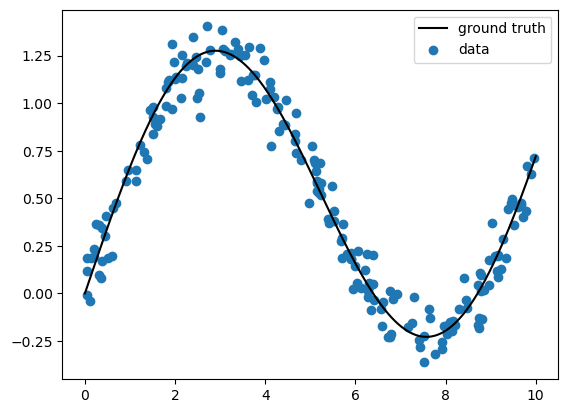

In [69]:
plt.plot(x_new, f(x_new), label="ground truth", color="black")
plt.scatter(x_data, b, label="data")
plt.legend()
plt.show()

# Solve with GKS

In [70]:
N = len(x_new)
L, _ = jlinops.first_order_derivative_1d(len(x_new), boundary="none")
L = L.toarray()

# define tikhonov family
tf = TikhonovFamily(A, L, b, None, btrue=btrue, noise_var=noise_sigma**2)
gsvd = tf.gsvd

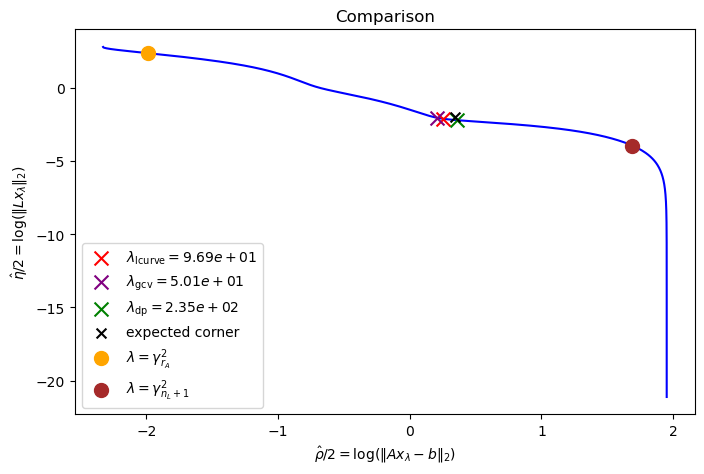

In [71]:
all_methods = all_regparam_methods(tf)
plot_all_methods(all_methods)
#plot_all_methods(all_methods, plot_path="deblur_all_methods.png")

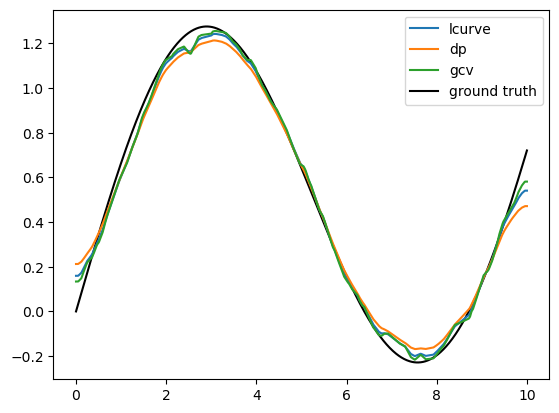

In [72]:
plt.plot(x_new, all_methods["lcurve_data"]["x_lambdah"], label="lcurve")
plt.plot(x_new, all_methods["dp_data"]["x_lambdah"], label="dp")
plt.plot(x_new, all_methods["gcv_data"]["x_lambdah"], label="gcv")
plt.plot(x_new, f(x_new), label="ground truth", zorder=-10, alpha=1.0, color="black")
plt.legend()
plt.show()